In [1]:
import keras.datasets.mnist as mnist
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, AveragePooling2D
from keras.models import Sequential
from tensorflow import nn
from numpy import argmax, mean, array, uint8, genfromtxt, max
from PIL import Image, ImageChops
from pandas import DataFrame
from matplotlib import cm
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from os.path import exists
%matplotlib inline

import anvil.server
import anvil.media as media

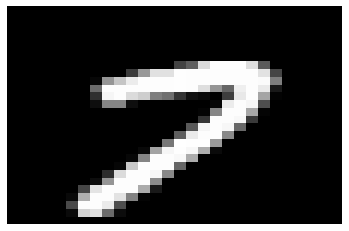

In [2]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

ndata_train = x_train.shape[0]
ndata_test = x_test.shape[0]

plt.pcolor( x_train[911,::-1,:] , cmap = 'gray' );
plt.axis('off');

In [3]:
x_train = x_train.reshape((ndata_train,28,28,1))
x_test = x_test.reshape((ndata_test,28,28,1))
xshape = x_train.shape[1:4]

In [4]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=xshape,padding="same"))
    model.add(MaxPooling2D(pool_size=(3,3), strides=1))
    model.add(Conv2D(filters=64,kernel_size=(3,3),activation=nn.relu))
    model.add(MaxPooling2D(pool_size=(4,4), strides=2))
    model.add(Conv2D(filters=128,kernel_size=(3,3),activation=nn.relu))
    model.add(MaxPooling2D(pool_size=(4,4), strides=2))
    model.add(Flatten())
    model.add(Dense(100,activation=nn.tanh))
    model.add(Dense(80,activation=nn.tanh))
    model.add(Dense(60,activation=nn.tanh))
    model.add(Dense(40,activation=nn.tanh))
    model.add(Dense(20,activation=nn.tanh))
    model.add(Dense(10,activation=nn.softmax))
    model.compile(optimizer='Nadam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

    return model

In [5]:
model = create_model()
display(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)        0

None

In [6]:
if exists('./model_weights/cnn_model.index'):
    display("Loading saved weights from trained model")
    model.load_weights('./model_weights/cnn_model')
else:
    display("Training the model")

    callback = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        min_delta=0.0002,
        restore_best_weights=True,
        verbose=1
    )
    
    history = model.fit(x_train,y_train,epochs=30,validation_split=0.2,batch_size=128, verbose=1, callbacks=[callback])
    
    model.save_weights('./model_weights/cnn_model')

    fig, axs = plt.subplots(figsize=(10,10))
    axs.plot(history.history['accuracy'])
    axs.plot(history.history['val_accuracy'])
    axs.title.set_text('Training Accuracy vs Validation Accuracy')
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Accuracy')
    axs.legend(['Train','Validation'])
    plt.show()

'Loading saved weights from trained model'

In [7]:
pred_probs2 = model.predict(x_test)
pred2 = argmax(pred_probs2, axis=1)
print(mean(pred2==y_test))

313/313 [==============================] - 8s 3ms/step
0.9931


In [8]:
ss = DataFrame(pred_probs2, columns = map(str, range(10)))
ss["pred_y"] = argmax(pred_probs2, axis=1)
ss["pred_y_prob"] = max(pred_probs2, axis=1)
ss["true_y"] = y_test
ss["correct"] = ss["pred_y"] == ss["true_y"]
x_test = x_test.reshape((ndata_test,28,28))

def plot_digit(index, number, wrong=None):
    img = Image.fromarray((x_test[index,:,:]*255).astype(int)).convert("L")
    img = ImageChops.invert(img)
    if type(wrong) == type(None):
        img.save(f"./correct/{number}_correct.png")
    else:
        img.save(f"./wrong/{number}_as_{wrong}.png")

In [ ]:
df_correct = ss.loc[ss[ss["correct"] == True].groupby("true_y")["pred_y_prob"].idxmax().to_list()][["true_y", "pred_y"]].reset_index()
df_correct.apply(lambda x: plot_digit(x["index"], x["true_y"]), axis=1)
ss.loc[ss[ss["correct"] == True].groupby("true_y")["pred_y_prob"].idxmax().to_list()]

In [9]:
df_correct = ss.loc[ss[ss["correct"] == False].groupby("true_y")["pred_y_prob"].idxmax().to_list()][["true_y", "pred_y"]].reset_index()
df_correct.apply(lambda x: plot_digit(x["index"], x["true_y"], x["pred_y"]), axis=1)
ss.loc[ss[ss["correct"] == False].groupby("true_y")["pred_y_prob"].idxmax().to_list()]

,0,1,2,3,4,5,6,7,8,9,pred_y,pred_y_prob,true_y,correct
6597,0.016534,0.000211,0.038145,0.004227,0.000465,0.000768,0.000029,0.919432,0.000308,0.019881,7,0.919432,0,False
3073,0.001474,0.312822,0.555509,0.028133,0.005121,0.002372,0.000751,0.092094,0.001146,0.000577,2,0.555509,1,False
2462,0.991881,0.000124,0.004630,0.000082,0.000304,0.000117,0.001098,0.001320,0.000410,0.000035,0,0.991881,2,False
2927,0.000083,0.000006,0.997506,0.001126,0.000101,0.000056,0.000039,0.000529,0.000376,0.000179,2,0.997506,3,False
2130,0.000010,0.000087,0.000076,0.000186,0.001083,0.000153,0.000045,0.000219,0.000218,0.997923,9,0.997923,4,False
2597,0.000006,0.000044,0.000189,0.999070,0.000085,0.000245,0.000029,0.000059,0.000073,0.000201,3,0.999070,5,False
3422,0.999493,0.000026,0.000053,0.000005,0.000087,0.000060,0.000196,0.000071,0.000002,0.000008,0,0.999493,6,False
6576,0.000075,0.971065,0.000214,0.000414,0.000466,0.000550,0.000141,0.022093,0.000478,0.004502,1,0.971065,7,False
947,0.000024,0.000198,0.000448,0.000151,0.000235,0.000149,0.000043,0.000562,0.007010,0.991180,9,0.991180,8,False
6571,0.000210,0.000349,0.000267,0.000593,0.000023,0.000504,0.000019,0.993983,0.000206,0.003846,7,0.993983,9,False


In [25]:
ss[ss["correct"] == False].groupby(["true_y", "pred_y"])["correct"].count().sort_values(ascending=False)[:6]

true_y  pred_y
4       9         8
6       0         4
9       7         4
2       7         4
7       1         4
9       4         3
Name: correct, dtype: int64

In [ ]:
# anvil.server.connect("KMEBVCDFSCHUX7VSXBGVW4CA-EJ5Y47DPV3JMGJSX")
anvil.server.connect("server_AQ6743JAYIROHH2QVXGNQ24A-36GVKNA22JCA3GF4")

@anvil.server.callable
def classify_image(arr):
    return argmax(model(array([arr]))[0].numpy())

anvil.server.wait_forever()

In [ ]:
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)

visualkeras.layered_view(model, legend=True, font=font, draw_volume= True,spacing=30, to_file='output.png')
visualkeras.layered_view(model, legend=True, font=font, draw_volume= True,spacing=30)

In [ ]:
from keras import layers
from collections import defaultdict
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#e25b9d' #'#1DA462'
color_map[layers.MaxPooling2D]['fill'] = '#0032b9' #'#FFCD46'
color_map[layers.Flatten]['fill'] = '#b3740a' #'#4C8BF5'
color_map[layers.Dense]['fill'] = '#22aebb' #'#DD5144'
visualkeras.layered_view(model, legend=True, font=font,color_map=color_map,spacing=50, to_file='output.png')
visualkeras.layered_view(model, legend=True, font=font,color_map=color_map,spacing=50)

In [ ]:
from PIL import Image
import numpy as np

im = Image.open("7_test.png").convert('L')
a = np.asarray(im)
np.savetxt("7_test.csv", a, fmt='%i', delimiter=",")

In [ ]:
np.array_equal((np.rint(a)).astype(int), a)

In [ ]:
a.dtype == np.dtype('uint8') and (a.max() > 255 or a.min() < 0)
a.dtype == np.dtype('float64') and (a.max() > 1 or a.min() < 0)

In [ ]:
np.array([4.]).dtype